In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Step 1: analysis of PCs (no metadata)

In [2]:
evals = pd.read_csv('../pca/results/ukb_pca_plink2.eigenval',delim_whitespace=True,header=None)
evecs = pd.read_csv('../pca/results/ukb_pca_plink2.eigenvec',delim_whitespace=True)

### Biplots of PCs 1-20

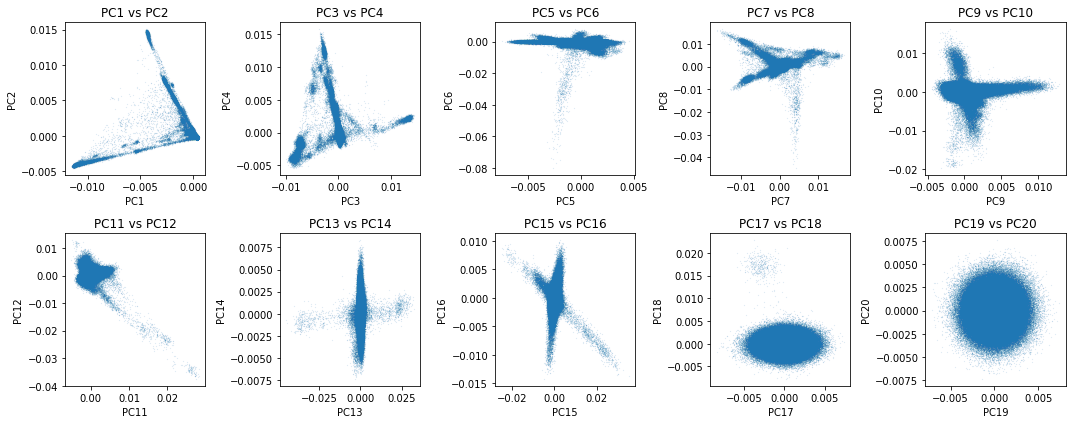

In [11]:
num_pcs = 20
fig, axes = plt.subplots(nrows=2,ncols=5,figsize=(15,6))
axes = axes.flatten()
for i in range(0, num_pcs, 2):
    pc1_col = f'PC{i+1}'
    pc2_col = f'PC{i+2}'
    axes[i // 2].scatter(evecs[pc1_col], evecs[pc2_col], s=0.01, alpha=0.5)
    axes[i // 2].set_title(f'{pc1_col} vs {pc2_col}')
    axes[i // 2].set_xlabel(pc1_col)
    axes[i // 2].set_ylabel(pc2_col)
plt.tight_layout()
plt.show()

### Eigenvalues and standard deviation

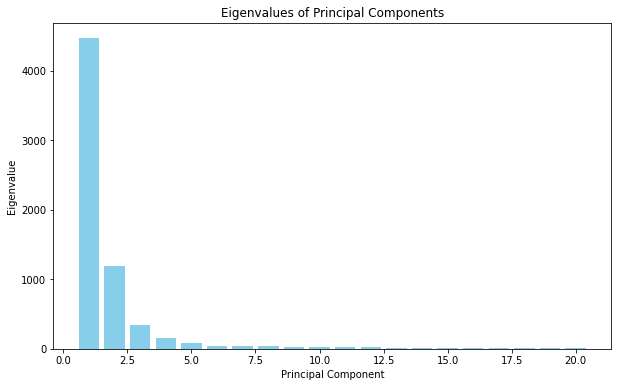

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(evals) + 1), evals[0], color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Principal Components')
plt.show()

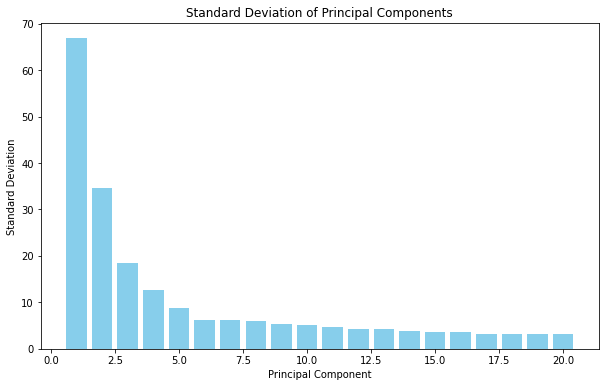

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(evals) + 1), [np.sqrt(e) for e in evals[0]], color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Principal Components')
plt.show()

## Step 2: Load in metadata and create dataframe

In [35]:
meta = pd.read_csv('../metadata/participant_metadata.csv')
wes_ids = pd.read_csv('../metadata/wes_ids.txt',delim_whitespace=True,header=None)
wgs_ids = pd.read_csv('../metadata/wes_ids.txt',delim_whitespace=True,header=None)

In [37]:
# format metadata

meta = meta.rename(columns={'participant.eid':'id'})

# undo codings
meta['participant.p54_i0'] = meta['participant.p54_i0'].astype(str)
center_coding = pd.read_csv("codings/coding10.tsv",delimiter="\t",names=["participant.p54_i0","assessment_center"],header=0)
center_dict = dict(zip(center_coding['participant.p54_i0'].astype(str),center_coding['assessment_center']))
meta['assessment_center'] = meta['participant.p54_i0'].map(center_dict)
meta = meta.drop('participant.p54_i0',axis=1)

meta['participant.p21000_i0'] = meta['participant.p21000_i0'].astype(str)
meta['participant.p21000_i0'] = meta['participant.p21000_i0'].str.replace(r'\.0$', '',regex=True)
ethnicity_coding = pd.read_csv("codings/coding1001.tsv",delimiter="\t",usecols=[0,1],names=["participant.p21000_i0","ethnic_background"],header=0)
ethnicity_dict = dict(zip(ethnicity_coding['participant.p21000_i0'].astype(str),ethnicity_coding['ethnic_background']))
meta['ethnic_background'] = meta['participant.p21000_i0'].map(ethnicity_dict)
meta = meta.drop('participant.p21000_i0',axis=1)

meta['participant.p1647_i0'] = meta['participant.p1647_i0'].astype(str)
meta['participant.p1647_i0'] = meta['participant.p1647_i0'].str.replace(r'\.0$', '',regex=True)
birth_UKelsewhere_coding = pd.read_csv("codings/coding100420.tsv",delimiter="\t",usecols=[0,1],names=["participant.p1647_i0","birth_UKelsewhere"],header=0)
birth_UKelsewhere_dict = dict(zip(birth_UKelsewhere_coding['participant.p1647_i0'].astype(str),birth_UKelsewhere_coding['birth_UKelsewhere']))
meta['birth_UKelsewhere'] = meta['participant.p1647_i0'].map(birth_UKelsewhere_dict)
meta = meta.drop('participant.p1647_i0',axis=1)

meta['participant.p20115_i0'] = meta['participant.p20115_i0'].astype(str)
meta['participant.p20115_i0'] = meta['participant.p20115_i0'].str.replace(r'\.0$', '',regex=True)
birth_nonUK_coding = pd.read_csv("codings/coding89.tsv",delimiter="\t",usecols=[0,1],names=["participant.p20115_i0","birth_nonUK"],header=0)
birth_nonUK_dict = dict(zip(birth_nonUK_coding['participant.p20115_i0'].astype(str),birth_nonUK_coding['birth_nonUK']))
meta['birth_nonUK'] = meta['participant.p20115_i0'].map(birth_nonUK_dict)
meta = meta.drop('participant.p20115_i0',axis=1)

# in coordinates, replace -1 with NA
meta = meta.rename(columns={'participant.p130_i0':'birth_east_coord','participant.p129_i0':'birth_north_coord'})
meta.loc[meta['birth_east_coord'] == -1, 'birth_east_coord'] = pd.NA
meta.loc[meta['birth_north_coord'] == -1, 'birth_north_coord'] = pd.NA


### Add in PCs

In [45]:
evecs = evecs.rename(columns={'IID':'id'})
meta_pcs = pd.merge(meta,evecs.iloc[:,1:],on='id',how='left')

In [47]:
meta_pcs.to_csv('meta_pcs.csv',index=False)

## Step 3: Descriptive plots

* PCA labeled by metadata
* PCs by birthplace coordinates
* Diversity by center

### Biplots - color by ethnic background

In [155]:
meta_pcs['ethnic_background'] = meta_pcs['ethnic_background'].replace(['Mixed','Any other mixed background'],'Mixed background')
meta_pcs['ethnic_background'] = meta_pcs['ethnic_background'].replace(['Other ethnic group','Prefer not to answer','Do not know'],'Other/unknown')
meta_pcs['ethnic_background'] = meta_pcs['ethnic_background'].fillna('Other/unknown')

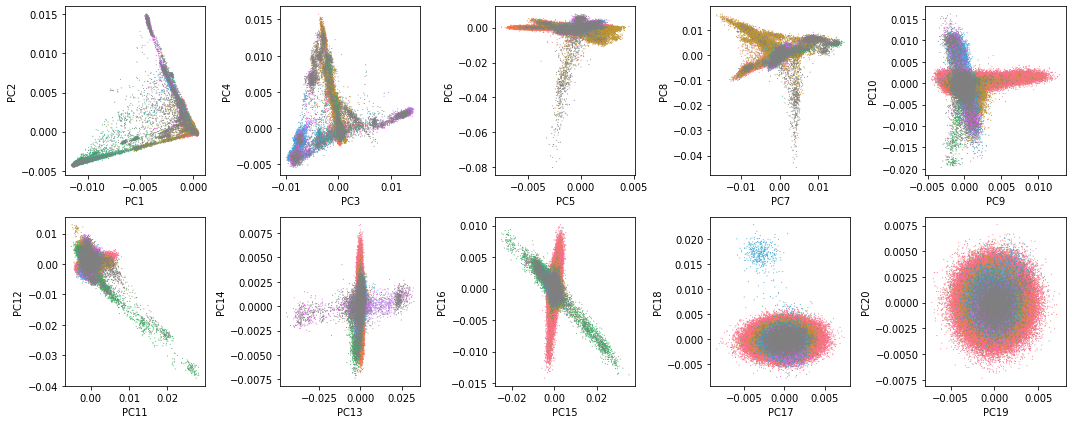

In [156]:
plt.rcParams['figure.figsize'] = [15, 6]

num_pcs = 20

unique_categories = ['British', 'Irish', 'White', 'Any other white background',
                    'White and Black Caribbean', 'White and Black African', 'Black or Black British', 'African',
                    'Caribbean','Any other Black background', 'White and Asian', 'Asian or Asian British',
                    'Indian', 'Pakistani', 'Bangladeshi', 'Chinese', 'Any other Asian background',
                    'Mixed background', 'Other/unknown']

color_palette = sns.color_palette('husl', n_colors=len(unique_categories))

color_palette[unique_categories.index('Mixed background')] = (0.5, 0.5, 0.5)  
color_palette[unique_categories.index('Other/unknown')] = (0.5, 0.5, 0.5)

category_colors = dict(zip(unique_categories, color_palette))

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

for i in range(0, num_pcs, 2):
    pc1_col = f'PC{i+1}'
    pc2_col = f'PC{i+2}'
    ax = axes[i // 2]

    for category, color in category_colors.items():
        category_data = meta_pcs[meta_pcs['ethnic_background'] == category]
        ax.scatter(x=category_data[pc1_col], y=category_data[pc2_col], s=1, color=color, label=category, edgecolor='none')

    ax.set_xlabel(pc1_col)
    ax.set_ylabel(pc2_col)

plt.tight_layout()
plt.show()


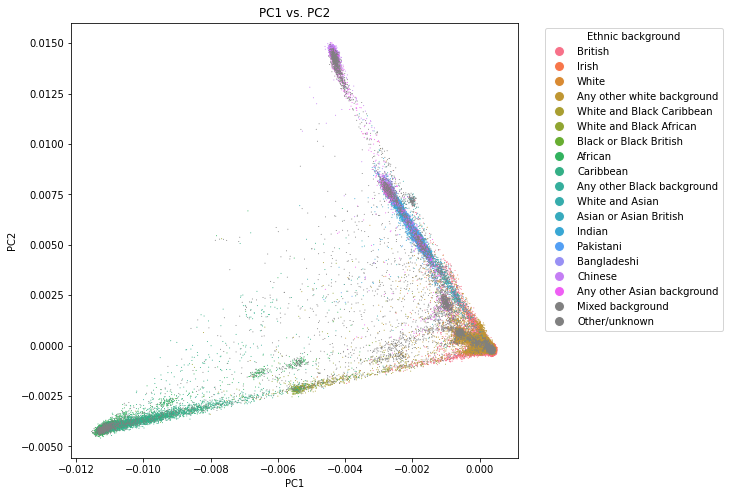

In [157]:
plt.figure(figsize=(8, 8))

legend_handles = []

for category, color in category_colors.items():
    category_data = meta_pcs[meta_pcs['ethnic_background'] == category]
    plt.scatter(x=category_data['PC1'], y=category_data['PC2'], s=1, color=color, label=category, edgecolor='none')

    # dummy bar plot for the legend
    dummy_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category)
    legend_handles.append(dummy_handle)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=legend_handles, title='Ethnic background', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PC1 vs. PC2')
plt.show()

### Single PC plots by ethnic background

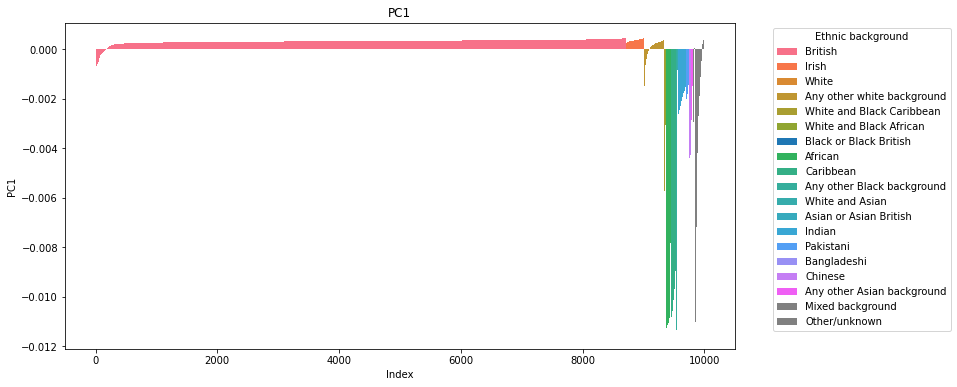

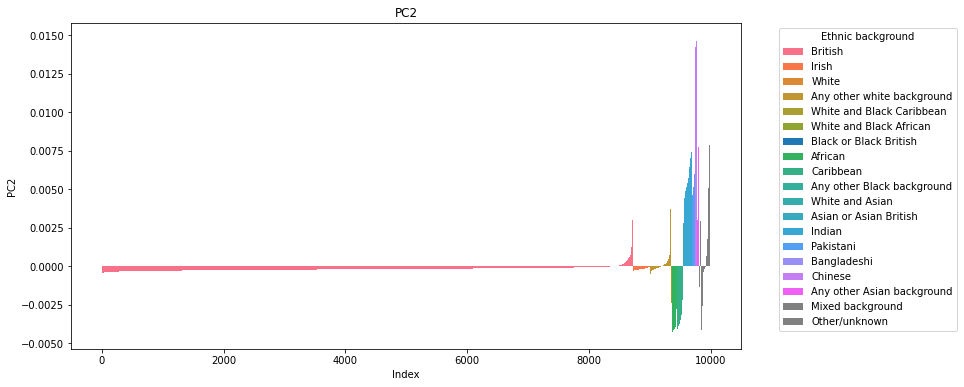

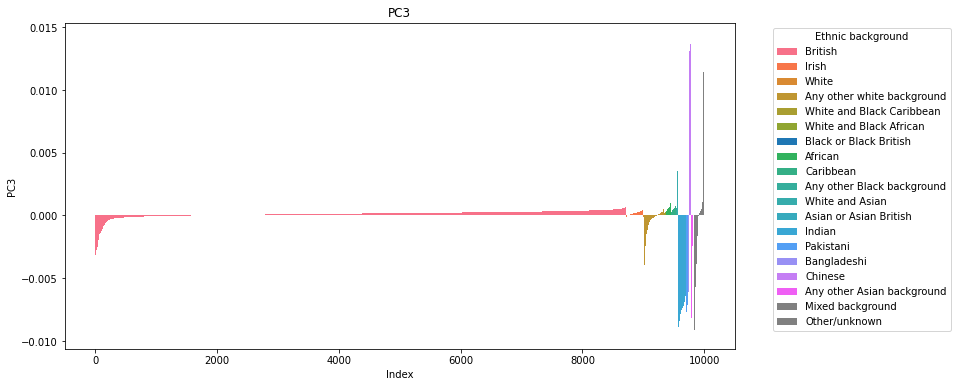

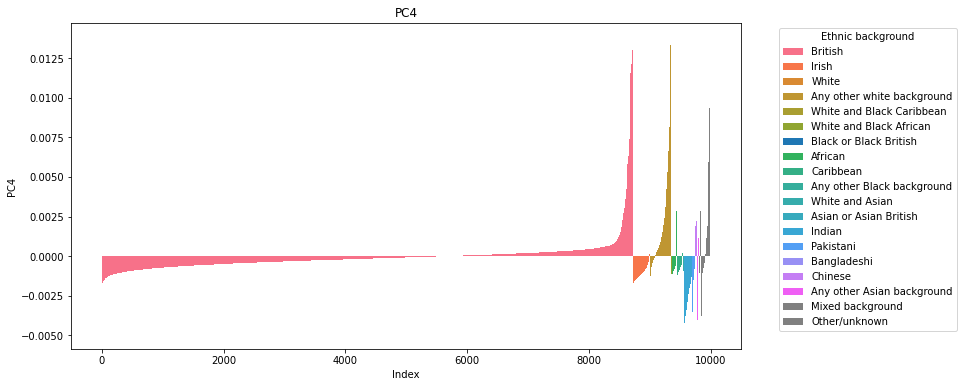

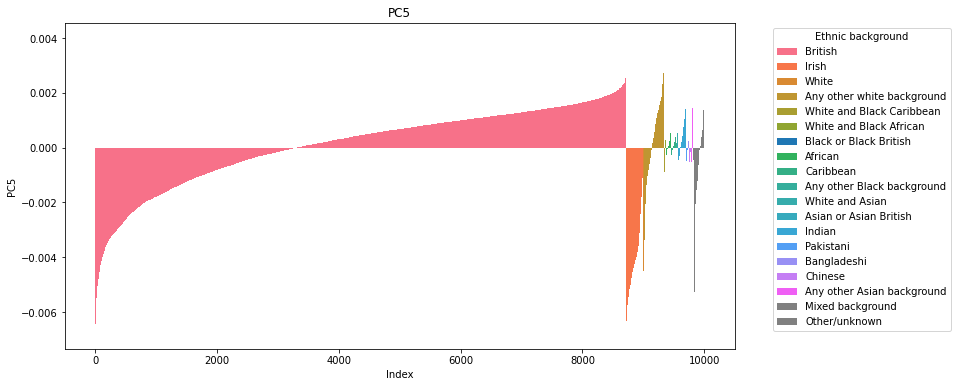

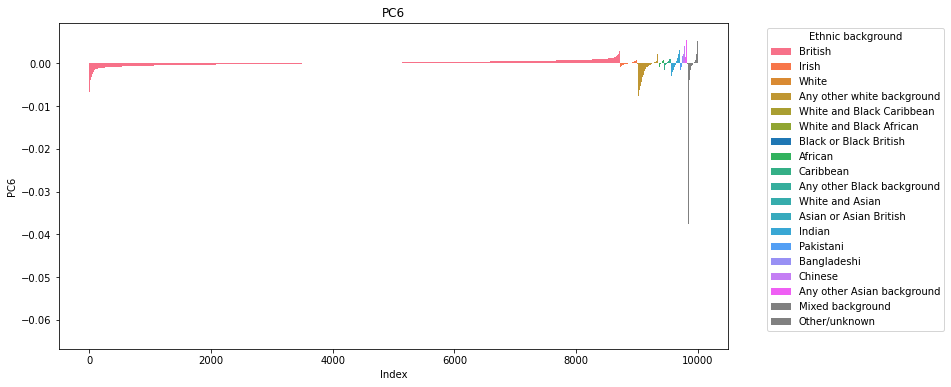

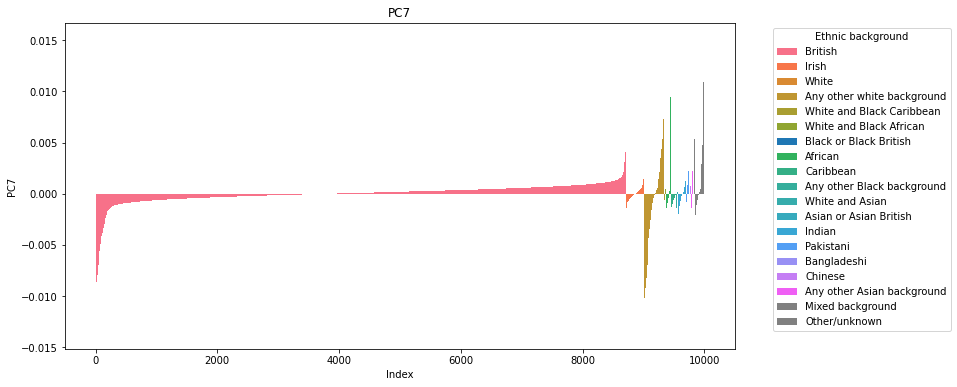

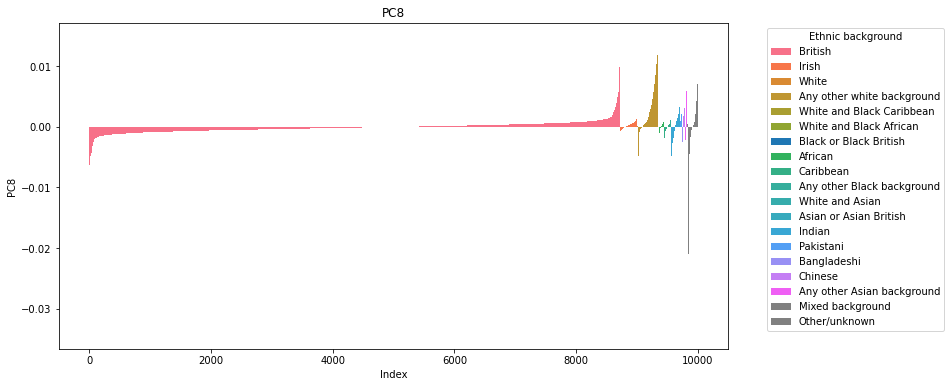

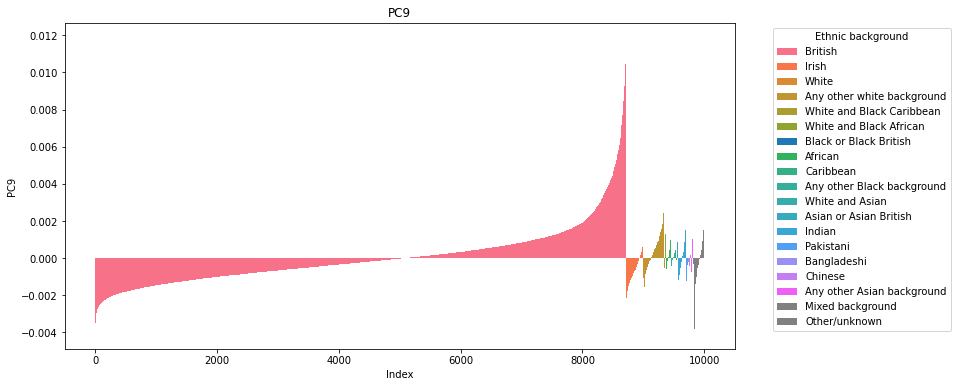

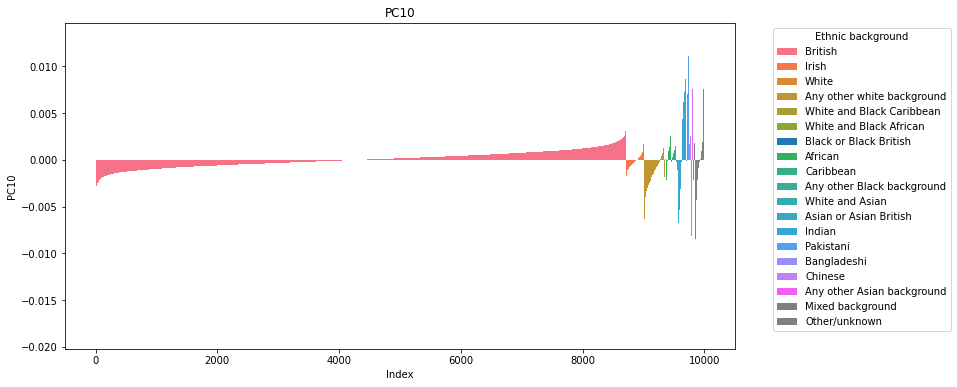

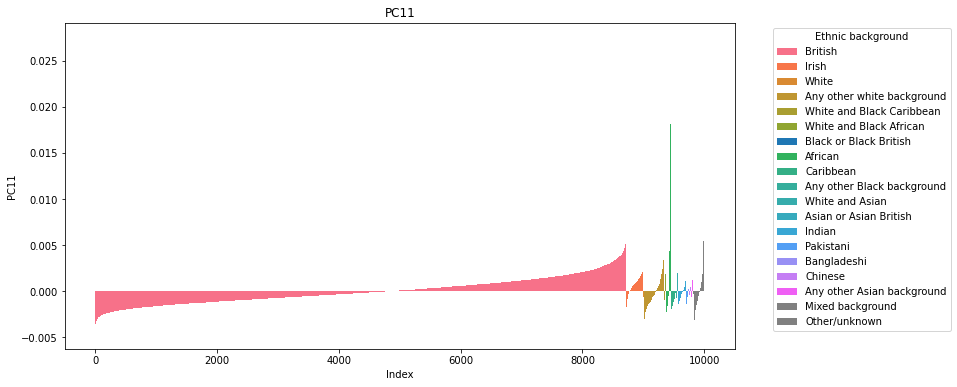

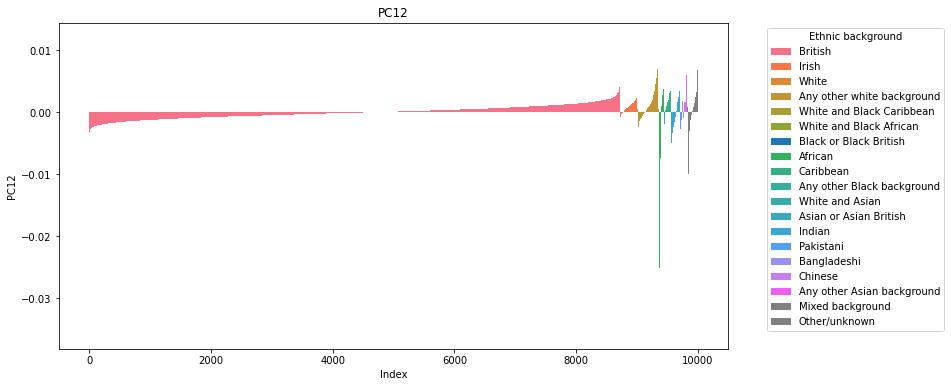

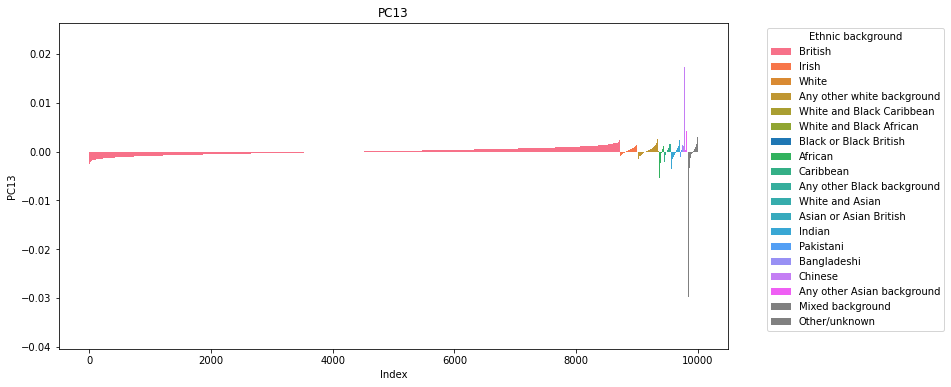

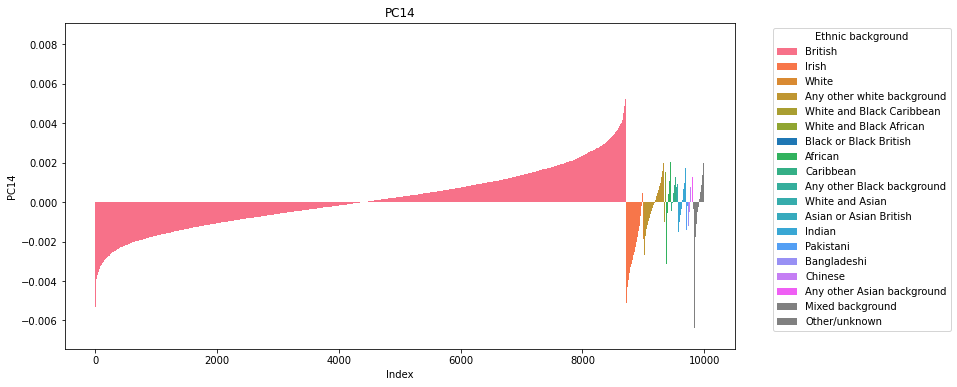

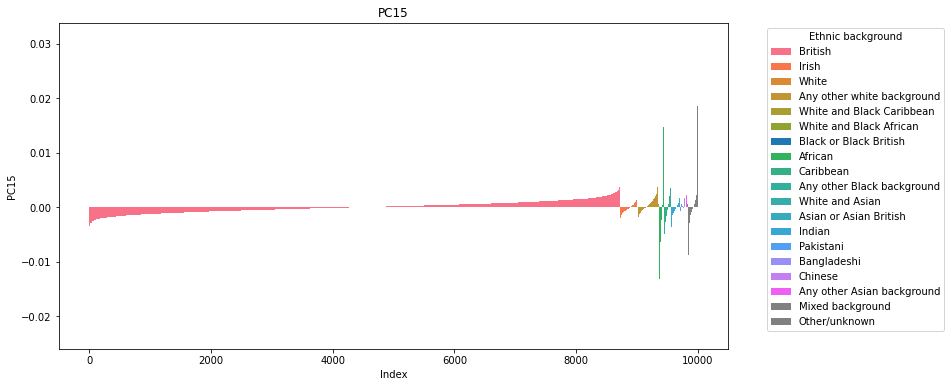

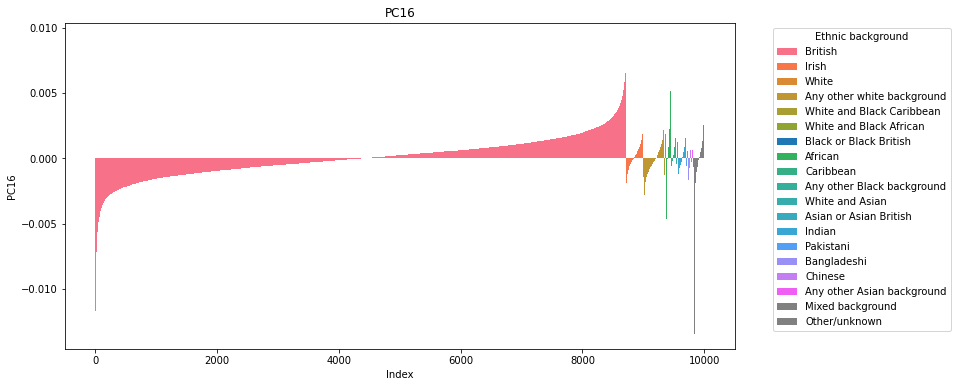

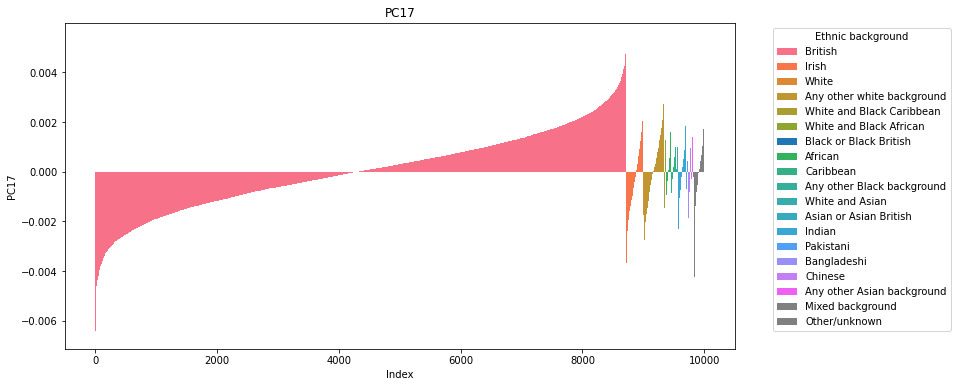

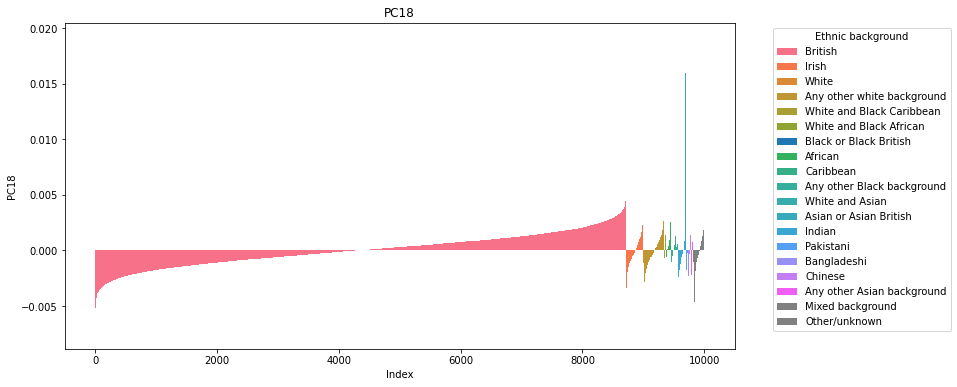

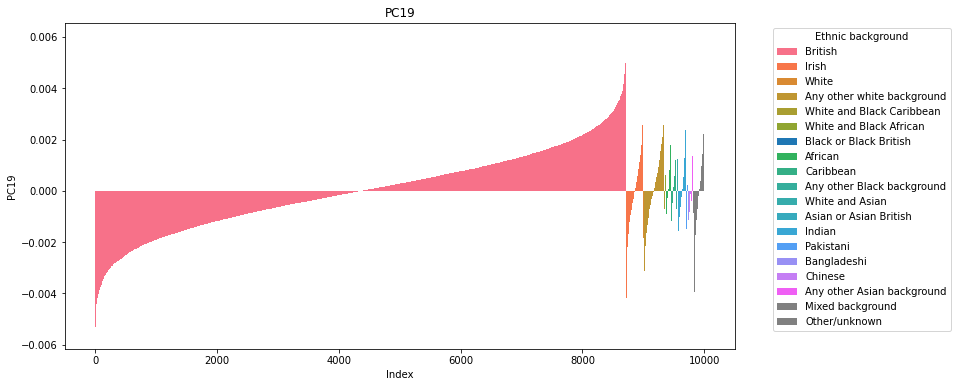

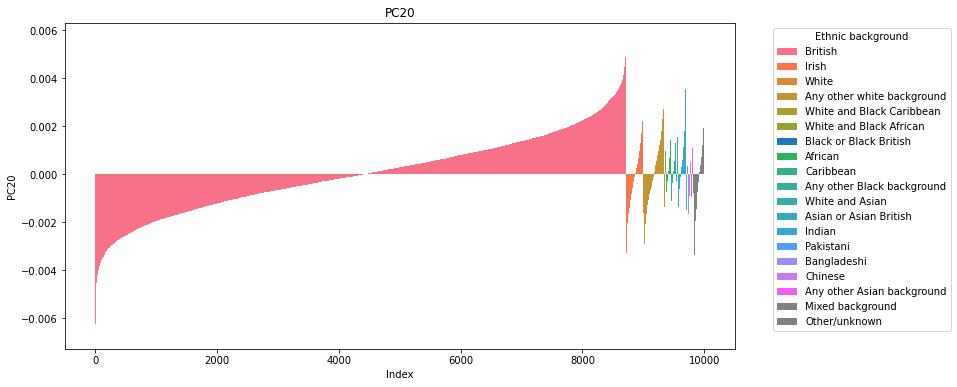

In [164]:
plt.rcParams['figure.figsize'] = [10, 6]

subsetsize=10000
seed = 0

# Loop through each principal component
for pc in meta_pcs.columns[-20:]:
    plt.figure(figsize=(12,6)) 
    subset_with_values = meta_pcs[meta_pcs['ethnic_background'].isin(unique_categories)].dropna(subset=[pc])
    
    subset_with_values['ethnic_background'] = pd.Categorical(subset_with_values['ethnic_background'], categories=unique_categories, ordered=True)
    sorted_cat_df = subset_with_values.sort_values(by='ethnic_background')
    
    random_subset = sorted_cat_df.sample(n=subsetsize, random_state=seed)
    sorted_df = random_subset.groupby('ethnic_background', group_keys=False).apply(lambda x: x.sort_values(by=pc)).reset_index(drop=True)

    for category, color in category_colors.items():
        category_data = sorted_df[sorted_df['ethnic_background'] == category]
        plt.bar(category_data.index, category_data[pc], color=color, label=category,width=1)

    plt.legend(title='Ethnic background', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Index')
    plt.ylabel(pc)
    plt.title(pc)
    plt.show()

### PCs by birthplace (UK only)

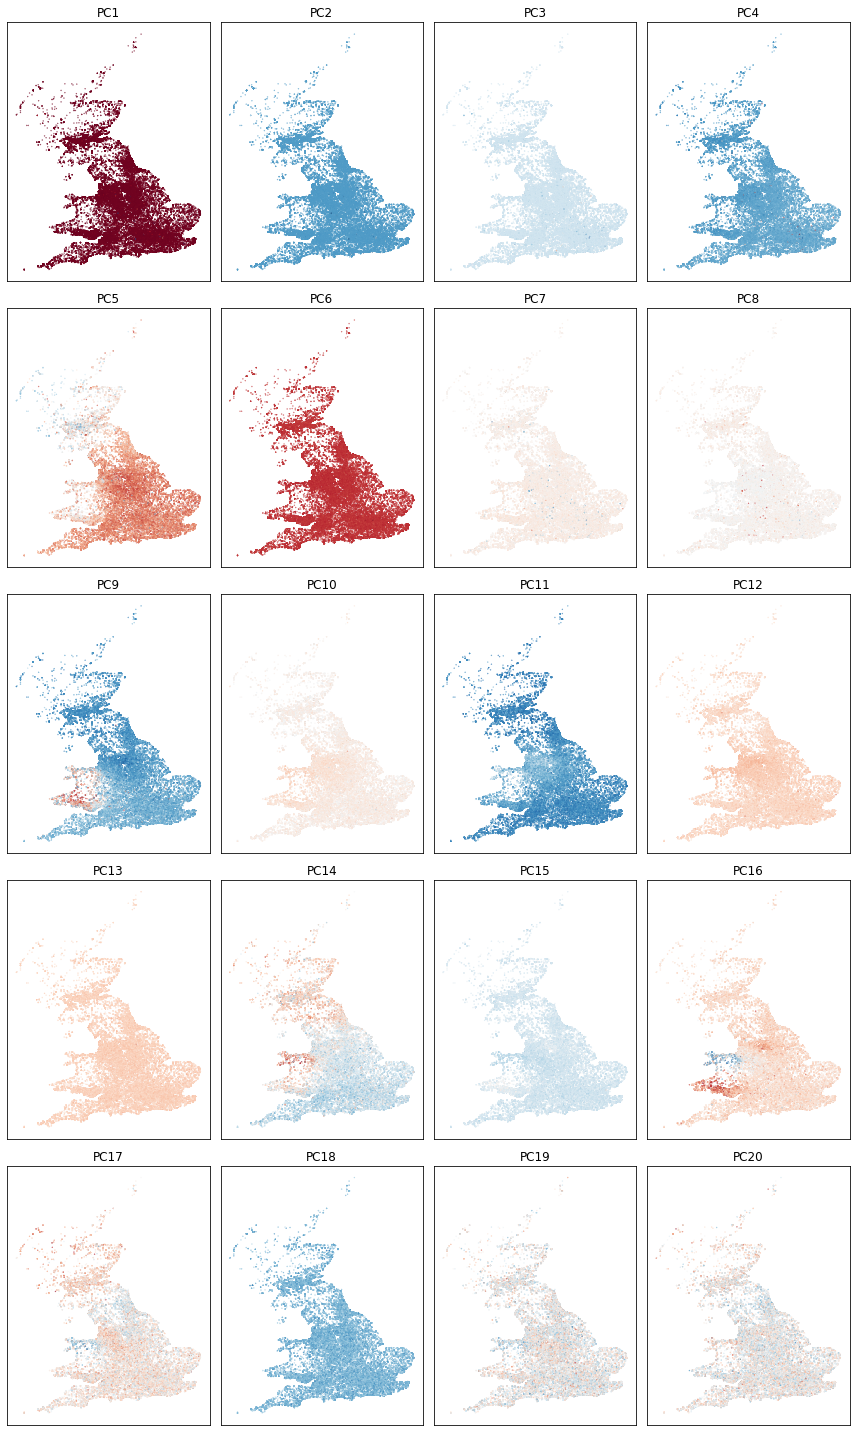

In [126]:
num_pcs = len(meta_pcs.columns[-20:])
num_rows = 5  
num_cols = int(np.ceil(num_pcs / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

for i, pc in enumerate(meta_pcs.columns[-20:]):
    row_idx = i // num_cols
    col_idx = i % num_cols
    scatter = axes[row_idx, col_idx].scatter(meta_pcs['birth_east_coord'], meta_pcs['birth_north_coord'], 
                                             c=meta_pcs[pc], cmap='RdBu_r', s=0.1)
    axes[row_idx, col_idx].set_title(pc)
    axes[row_idx, col_idx].set_xticks([])
    axes[row_idx, col_idx].set_yticks([])
    axes[row_idx, col_idx].set_xticklabels([])
    axes[row_idx, col_idx].set_yticklabels([])
plt.tight_layout()
plt.show()


### Standard deviation in PC space by sampling center

In [133]:
centers = meta_pcs['assessment_center'].unique()
center_pc_sds = []
for center in centers:
    sds_temp = []
    for pc in meta_pcs.columns[-20:]:
        sds_temp.append(meta_pcs.loc[meta_pcs['assessment_center']==center,pc].std())
    center_pc_sds.append(np.mean(sds_temp))


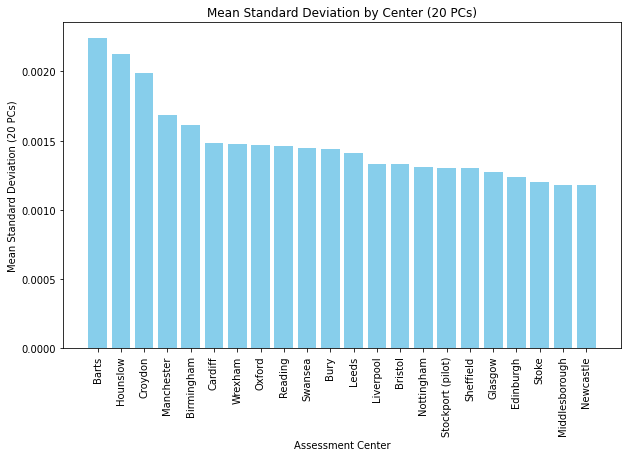

In [141]:
center_sds_df = pd.DataFrame({'center':centers,'mean_sd':center_pc_sds})
center_sds_df_sorted = center_sds_df.sort_values(by='mean_sd',ascending=False)
plt.figure(figsize=(10,6))
plt.bar(center_sds_df_sorted['center'],center_sds_df_sorted['mean_sd'],color='skyblue')
plt.xticks(rotation='vertical')
plt.xlabel('Assessment Center')
plt.ylabel('Mean Standard Deviation (20 PCs)')
plt.title('Mean Standard Deviation by Center (20 PCs)')
plt.show()

### Ethnic background by sampling center

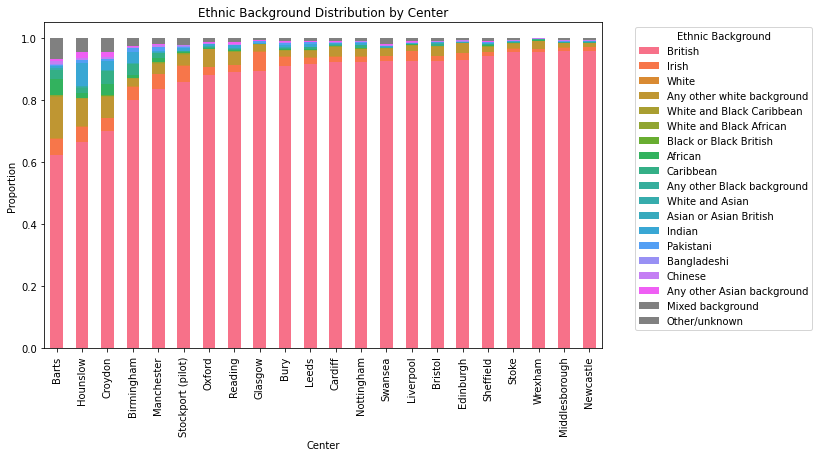

In [159]:
df_filt = meta_pcs[meta_pcs['ethnic_background'].isin(unique_categories)]
grouped_df = df_filt.groupby(['assessment_center','ethnic_background']).size().unstack(fill_value=0)


proportions_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)
proportions_df = proportions_df.sort_values(by='British', ascending=True)
proportions_df = proportions_df[unique_categories]
proportions_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=[category_colors[col] for col in proportions_df.columns])

plt.xlabel('Center')
plt.ylabel('Proportion')
plt.title('Ethnic Background Distribution by Center')
plt.legend(title='Ethnic Background', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()